In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpgrlsau5p


In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
split_json = "dataset_3.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


image shape: torch.Size([1, 256, 226, 244]), label shape: torch.Size([1, 256, 226, 244])


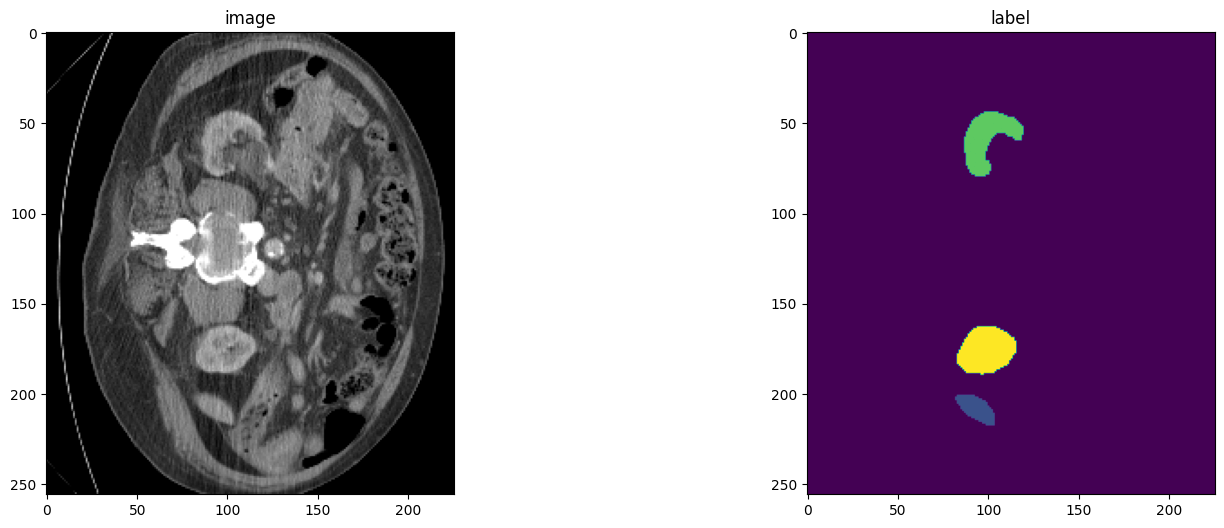

In [10]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
slice_map = {
    "img0007.nii.gz": 125,
    "img0008.nii.gz": 230,
    "img0009.nii.gz": 204,
    "img0010.nii.gz": 204,
    "img0021.nii.gz": 204,
    "img0022.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [12]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [13]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [14]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.46281): 100%|█| 24/24 [00:23<00:00,  1.04it/
Training (47 / 25000 Steps) (loss=2.26882): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=2.09504): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=1.71592): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (119 / 25000 Steps) (loss=1.88379): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (143 / 25000 Steps) (loss=1.92413): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (167 / 25000 Steps) (loss=1.82216): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (191 / 25000 Steps) (loss=1.62052): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (215 / 25000 Steps) (loss=1.58818): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (239 / 25000 Steps) (loss=1.68065): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (263 / 25000 Steps) (loss=1.59498): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.64944): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.21795137226581573 Current Avg. Dice: 0.21795137226581573


Training (503 / 25000 Steps) (loss=1.28678): 100%|█| 24/24 [00:33<00:00,  1.38s/
Training (527 / 25000 Steps) (loss=1.15575): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (551 / 25000 Steps) (loss=1.23163): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (575 / 25000 Steps) (loss=1.23740): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (599 / 25000 Steps) (loss=1.24057): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=1.20159): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.28405): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (671 / 25000 Steps) (loss=1.09609): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (695 / 25000 Steps) (loss=1.13360): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (719 / 25000 Steps) (loss=1.11286): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.09802): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.14593): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4063797891139984 Current Avg. Dice: 0.4063797891139984


Training (1007 / 25000 Steps) (loss=1.00513): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1031 / 25000 Steps) (loss=1.02750): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1055 / 25000 Steps) (loss=1.22348): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1079 / 25000 Steps) (loss=1.02358): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1103 / 25000 Steps) (loss=1.12496): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1127 / 25000 Steps) (loss=0.84934): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.00445): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.06607): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1199 / 25000 Steps) (loss=0.96682): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1223 / 25000 Steps) (loss=1.31008): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1247 / 25000 Steps) (loss=0.86548): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1271 / 25000 Steps) (loss=0.84189): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5194602608680725 Current Avg. Dice: 0.5194602608680725


Training (1511 / 25000 Steps) (loss=0.95859): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (1535 / 25000 Steps) (loss=1.16639): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1559 / 25000 Steps) (loss=0.90321): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1583 / 25000 Steps) (loss=0.89412): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1607 / 25000 Steps) (loss=0.91238): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (1631 / 25000 Steps) (loss=1.06046): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (1655 / 25000 Steps) (loss=0.87524): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1679 / 25000 Steps) (loss=0.93166): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1703 / 25000 Steps) (loss=0.79914): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1727 / 25000 Steps) (loss=0.84596): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1751 / 25000 Steps) (loss=0.81218): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1775 / 25000 Steps) (loss=0.65033): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6127505302429199 Current Avg. Dice: 0.6127505302429199


Training (2015 / 25000 Steps) (loss=0.84805): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (2039 / 25000 Steps) (loss=0.70620): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2063 / 25000 Steps) (loss=0.79218): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2087 / 25000 Steps) (loss=0.84327): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2111 / 25000 Steps) (loss=0.80968): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2135 / 25000 Steps) (loss=0.66733): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2159 / 25000 Steps) (loss=0.71774): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2183 / 25000 Steps) (loss=0.77788): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2207 / 25000 Steps) (loss=0.79371): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2231 / 25000 Steps) (loss=0.78826): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.70728): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=0.78381): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6597201824188232 Current Avg. Dice: 0.6597201824188232


Training (2519 / 25000 Steps) (loss=0.91012): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (2543 / 25000 Steps) (loss=0.81207): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2567 / 25000 Steps) (loss=0.67671): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.61241): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2615 / 25000 Steps) (loss=0.78481): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2639 / 25000 Steps) (loss=0.78910): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.67271): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2687 / 25000 Steps) (loss=0.81989): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2711 / 25000 Steps) (loss=0.67223): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2735 / 25000 Steps) (loss=0.86011): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.61515): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2783 / 25000 Steps) (loss=0.67074): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6597201824188232 Current Avg. Dice: 0.649267852306366


Training (3023 / 25000 Steps) (loss=0.84068): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (3047 / 25000 Steps) (loss=0.72305): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.70998): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3095 / 25000 Steps) (loss=0.72092): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=0.88546): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.77544): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3167 / 25000 Steps) (loss=0.73681): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3191 / 25000 Steps) (loss=0.82265): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3215 / 25000 Steps) (loss=0.75566): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.72667): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3263 / 25000 Steps) (loss=0.67673): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3287 / 25000 Steps) (loss=0.46339): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6597201824188232 Current Avg. Dice: 0.6594066619873047


Training (3503 / 25000 Steps) (loss=0.77728): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (3527 / 25000 Steps) (loss=0.49184): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3551 / 25000 Steps) (loss=0.81157): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3575 / 25000 Steps) (loss=0.70554): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3599 / 25000 Steps) (loss=0.58631): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3623 / 25000 Steps) (loss=0.66935): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.69426): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3671 / 25000 Steps) (loss=0.52336): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3695 / 25000 Steps) (loss=0.78178): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.75119): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3743 / 25000 Steps) (loss=0.75741): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.75963): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.694783627986908 Current Avg. Dice: 0.694783627986908


Training (4007 / 25000 Steps) (loss=0.72231): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (4031 / 25000 Steps) (loss=0.73578): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.75099): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4079 / 25000 Steps) (loss=0.54168): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.70293): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4127 / 25000 Steps) (loss=0.71838): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.70182): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.78265): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.58009): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=0.55126): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.80622): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4271 / 25000 Steps) (loss=0.44391): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.694783627986908 Current Avg. Dice: 0.6907501220703125


Training (4511 / 25000 Steps) (loss=0.52425): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (4535 / 25000 Steps) (loss=0.64541): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4559 / 25000 Steps) (loss=0.73056): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4583 / 25000 Steps) (loss=0.60260): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4607 / 25000 Steps) (loss=0.70504): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4631 / 25000 Steps) (loss=0.64454): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.47279): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4679 / 25000 Steps) (loss=0.88412): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.70714): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.78979): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.66598): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4775 / 25000 Steps) (loss=0.61175): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.694783627986908 Current Avg. Dice: 0.6896212697029114


Training (5015 / 25000 Steps) (loss=0.68170): 100%|█| 24/24 [00:31<00:00,  1.33s
Training (5039 / 25000 Steps) (loss=0.81908): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5063 / 25000 Steps) (loss=0.49275): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5087 / 25000 Steps) (loss=0.54763): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5111 / 25000 Steps) (loss=0.75283): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5135 / 25000 Steps) (loss=0.85858): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5159 / 25000 Steps) (loss=0.49116): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5183 / 25000 Steps) (loss=0.60649): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=0.72260): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5231 / 25000 Steps) (loss=0.65016): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5255 / 25000 Steps) (loss=0.75130): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5279 / 25000 Steps) (loss=0.71658): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6983702182769775 Current Avg. Dice: 0.6983702182769775


Training (5519 / 25000 Steps) (loss=0.61649): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (5543 / 25000 Steps) (loss=0.68126): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5567 / 25000 Steps) (loss=0.75298): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5591 / 25000 Steps) (loss=0.54224): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=0.62735): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.70547): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.50879): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.52845): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5711 / 25000 Steps) (loss=0.56536): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5735 / 25000 Steps) (loss=0.60609): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.41736): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5783 / 25000 Steps) (loss=0.77392): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7101709246635437 Current Avg. Dice: 0.7101709246635437


Training (6023 / 25000 Steps) (loss=0.64148): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6047 / 25000 Steps) (loss=0.48174): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6071 / 25000 Steps) (loss=0.60075): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6095 / 25000 Steps) (loss=1.09943): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.80011): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.53947): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6167 / 25000 Steps) (loss=0.52934): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6191 / 25000 Steps) (loss=0.63857): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.46410): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6239 / 25000 Steps) (loss=0.64167): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6263 / 25000 Steps) (loss=0.33610): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6287 / 25000 Steps) (loss=0.40687): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7101709246635437 Current Avg. Dice: 0.7074447274208069


Training (6503 / 25000 Steps) (loss=0.69580): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (6527 / 25000 Steps) (loss=0.41621): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6551 / 25000 Steps) (loss=0.55697): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6575 / 25000 Steps) (loss=0.68334): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.58572): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.55694): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6647 / 25000 Steps) (loss=0.53227): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.58958): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.53057): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.70088): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.54869): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6767 / 25000 Steps) (loss=0.69337): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7267794013023376


Training (7007 / 25000 Steps) (loss=0.70909): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (7031 / 25000 Steps) (loss=0.48179): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7055 / 25000 Steps) (loss=0.76714): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7079 / 25000 Steps) (loss=0.64953): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7103 / 25000 Steps) (loss=0.59577): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.51023): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7151 / 25000 Steps) (loss=0.52734): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7175 / 25000 Steps) (loss=0.65121): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7199 / 25000 Steps) (loss=0.48600): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7223 / 25000 Steps) (loss=0.72019): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.61292): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.65962): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7145169377326965


Training (7511 / 25000 Steps) (loss=0.50833): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (7535 / 25000 Steps) (loss=0.67061): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7559 / 25000 Steps) (loss=0.49872): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7583 / 25000 Steps) (loss=0.57915): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7607 / 25000 Steps) (loss=0.57199): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7631 / 25000 Steps) (loss=0.68868): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.60998): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7679 / 25000 Steps) (loss=0.63054): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7703 / 25000 Steps) (loss=0.68900): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.63723): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.76719): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7775 / 25000 Steps) (loss=0.47056): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7175309658050537


Training (8015 / 25000 Steps) (loss=0.59333): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (8039 / 25000 Steps) (loss=0.57433): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.63997): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8087 / 25000 Steps) (loss=0.72006): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8111 / 25000 Steps) (loss=0.64214): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8135 / 25000 Steps) (loss=0.64318): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.59335): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.76298): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.60620): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=0.76865): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.62737): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8279 / 25000 Steps) (loss=0.68557): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.719384491443634


Training (8519 / 25000 Steps) (loss=0.35793): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (8543 / 25000 Steps) (loss=0.52707): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8567 / 25000 Steps) (loss=0.54111): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8591 / 25000 Steps) (loss=0.54460): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8615 / 25000 Steps) (loss=0.78434): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8639 / 25000 Steps) (loss=0.63012): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8663 / 25000 Steps) (loss=0.68776): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.67662): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.64855): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=0.56643): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.48165): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8783 / 25000 Steps) (loss=0.88146): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7224257588386536


Training (9023 / 25000 Steps) (loss=0.42935): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (9047 / 25000 Steps) (loss=0.52576): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9071 / 25000 Steps) (loss=0.60139): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9095 / 25000 Steps) (loss=0.76213): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.80271): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9143 / 25000 Steps) (loss=0.61970): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9167 / 25000 Steps) (loss=0.70308): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9191 / 25000 Steps) (loss=0.80616): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.64932): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.53385): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9263 / 25000 Steps) (loss=0.45894): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9287 / 25000 Steps) (loss=0.53777): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7171081900596619


Training (9503 / 25000 Steps) (loss=0.56850): 100%|█| 24/24 [00:31<00:00,  1.33s
Training (9527 / 25000 Steps) (loss=0.54698): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9551 / 25000 Steps) (loss=0.37052): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9575 / 25000 Steps) (loss=0.64729): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9599 / 25000 Steps) (loss=0.71827): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.69688): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.62253): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.43767): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.58940): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.46994): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9743 / 25000 Steps) (loss=0.63714): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.55403): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7052841186523438


Training (10007 / 25000 Steps) (loss=0.73258): 100%|█| 24/24 [00:31<00:00,  1.32
Training (10031 / 25000 Steps) (loss=0.36179): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.63442): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10079 / 25000 Steps) (loss=0.62466): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.55194): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10127 / 25000 Steps) (loss=0.62687): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.71233): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10175 / 25000 Steps) (loss=0.79532): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10199 / 25000 Steps) (loss=0.52414): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.65551): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10247 / 25000 Steps) (loss=0.75493): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.46038): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7228550314903259


Training (10511 / 25000 Steps) (loss=0.45373): 100%|█| 24/24 [00:31<00:00,  1.32
Training (10535 / 25000 Steps) (loss=0.80887): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10559 / 25000 Steps) (loss=0.32159): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.60283): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.81052): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10631 / 25000 Steps) (loss=0.56972): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.67897): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10679 / 25000 Steps) (loss=0.44344): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.35798): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.79195): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.61370): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.54460): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7164590954780579


Training (11015 / 25000 Steps) (loss=0.48974): 100%|█| 24/24 [00:31<00:00,  1.33
Training (11039 / 25000 Steps) (loss=0.37229): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.49515): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.46102): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.49401): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11135 / 25000 Steps) (loss=0.59383): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.66587): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.54947): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11207 / 25000 Steps) (loss=0.66978): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11231 / 25000 Steps) (loss=0.48315): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.42640): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.50776): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7130892276763916


Training (11519 / 25000 Steps) (loss=0.59557): 100%|█| 24/24 [00:31<00:00,  1.32
Training (11543 / 25000 Steps) (loss=0.68265): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11567 / 25000 Steps) (loss=0.70986): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.64008): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.70626): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.36825): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.66950): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.45902): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.37729): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11735 / 25000 Steps) (loss=0.51002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.57934): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11783 / 25000 Steps) (loss=0.54941): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7068371772766113


Training (12023 / 25000 Steps) (loss=0.61542): 100%|█| 24/24 [00:31<00:00,  1.32
Training (12047 / 25000 Steps) (loss=0.83588): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.58321): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12095 / 25000 Steps) (loss=0.66932): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.73183): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12143 / 25000 Steps) (loss=0.67798): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12167 / 25000 Steps) (loss=0.54714): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.51448): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12215 / 25000 Steps) (loss=0.57287): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12239 / 25000 Steps) (loss=0.45965): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.51013): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12287 / 25000 Steps) (loss=0.36955): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.719893217086792


Training (12503 / 25000 Steps) (loss=0.43499): 100%|█| 24/24 [00:31<00:00,  1.33
Training (12527 / 25000 Steps) (loss=0.36622): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12551 / 25000 Steps) (loss=0.48853): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=0.74667): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12599 / 25000 Steps) (loss=0.71866): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12623 / 25000 Steps) (loss=0.84538): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.74109): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.45978): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.63425): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.57385): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.49990): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.67350): 100%|█| 24/24 [00:18<00:00,  1.26
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7267794013023376 Current Avg. Dice: 0.7154261469841003


Training (13007 / 25000 Steps) (loss=0.54830): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13031 / 25000 Steps) (loss=0.42387): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.61021): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.54927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.53344): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.56863): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.49784): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.54426): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.68515): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.48776): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.57617): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13271 / 25000 Steps) (loss=0.63056): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7268293499946594 Current Avg. Dice: 0.7268293499946594


Training (13511 / 25000 Steps) (loss=0.61827): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13535 / 25000 Steps) (loss=0.60057): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13559 / 25000 Steps) (loss=0.58344): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.39091): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13607 / 25000 Steps) (loss=0.68319): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.74592): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.61972): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.70867): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.48215): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=0.47029): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13751 / 25000 Steps) (loss=0.65086): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.55891): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7268293499946594 Current Avg. Dice: 0.7103396058082581


Training (14015 / 25000 Steps) (loss=0.61544): 100%|█| 24/24 [00:31<00:00,  1.33
Training (14039 / 25000 Steps) (loss=0.60938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.66239): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.60710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14111 / 25000 Steps) (loss=0.62314): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.54715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.54975): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.37560): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14207 / 25000 Steps) (loss=0.49856): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.45318): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14255 / 25000 Steps) (loss=0.38392): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=0.65645): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7268293499946594 Current Avg. Dice: 0.719720184803009


Training (14519 / 25000 Steps) (loss=0.66379): 100%|█| 24/24 [00:31<00:00,  1.33
Training (14543 / 25000 Steps) (loss=0.50997): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.59804): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.59156): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.47455): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14639 / 25000 Steps) (loss=0.38749): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.51813): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.69422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.54429): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.31347): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.42972): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14783 / 25000 Steps) (loss=0.80168): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7268293499946594 Current Avg. Dice: 0.7007115483283997


Training (15023 / 25000 Steps) (loss=0.57036): 100%|█| 24/24 [00:31<00:00,  1.32
Training (15047 / 25000 Steps) (loss=0.51297): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.42578): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.51203): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.54470): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.48450): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15167 / 25000 Steps) (loss=0.52451): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15191 / 25000 Steps) (loss=0.33445): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15215 / 25000 Steps) (loss=0.59366): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.27301): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15263 / 25000 Steps) (loss=0.51840): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.59395): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7268293499946594 Current Avg. Dice: 0.714911162853241


Training (15503 / 25000 Steps) (loss=0.58051): 100%|█| 24/24 [00:31<00:00,  1.32
Training (15527 / 25000 Steps) (loss=0.60144): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15551 / 25000 Steps) (loss=0.64110): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15575 / 25000 Steps) (loss=0.62957): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15599 / 25000 Steps) (loss=0.44135): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.62586): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15647 / 25000 Steps) (loss=0.70354): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15671 / 25000 Steps) (loss=0.45184): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15695 / 25000 Steps) (loss=0.78947): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.36731): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.62983): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15767 / 25000 Steps) (loss=0.84093): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.7344860434532166


Training (16007 / 25000 Steps) (loss=0.37922): 100%|█| 24/24 [00:32<00:00,  1.34
Training (16031 / 25000 Steps) (loss=0.60206): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16055 / 25000 Steps) (loss=0.49634): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16079 / 25000 Steps) (loss=0.46925): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16103 / 25000 Steps) (loss=0.45317): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.58432): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.57229): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.64472): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.61019): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16223 / 25000 Steps) (loss=0.46721): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.59068): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.68069): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.7322733402252197


Training (16511 / 25000 Steps) (loss=0.61215): 100%|█| 24/24 [00:31<00:00,  1.32
Training (16535 / 25000 Steps) (loss=0.65611): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16559 / 25000 Steps) (loss=0.41612): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16583 / 25000 Steps) (loss=0.62367): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16607 / 25000 Steps) (loss=0.67343): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.63575): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16655 / 25000 Steps) (loss=0.60340): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16679 / 25000 Steps) (loss=0.45099): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16703 / 25000 Steps) (loss=0.57005): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.54938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16751 / 25000 Steps) (loss=0.36004): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.49441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.727283239364624


Training (17015 / 25000 Steps) (loss=0.59977): 100%|█| 24/24 [00:31<00:00,  1.32
Training (17039 / 25000 Steps) (loss=0.62896): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.48777): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17087 / 25000 Steps) (loss=0.56422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17111 / 25000 Steps) (loss=0.37436): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.80808): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.64771): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.58333): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17207 / 25000 Steps) (loss=0.47115): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17231 / 25000 Steps) (loss=0.51260): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.50618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.61091): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.727300226688385


Training (17519 / 25000 Steps) (loss=0.45857): 100%|█| 24/24 [00:31<00:00,  1.33
Training (17543 / 25000 Steps) (loss=0.69355): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.79184): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.55926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=0.77418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.49599): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17663 / 25000 Steps) (loss=0.52301): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.63117): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.44983): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17735 / 25000 Steps) (loss=0.76950): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17759 / 25000 Steps) (loss=0.66240): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.63726): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.7299602031707764


Training (18023 / 25000 Steps) (loss=0.62213): 100%|█| 24/24 [00:31<00:00,  1.32
Training (18047 / 25000 Steps) (loss=0.69813): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.61923): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.71157): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.55165): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.58587): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.61422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.54812): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.74300): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18239 / 25000 Steps) (loss=0.71926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.31674): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.82531): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.7229061126708984


Training (18503 / 25000 Steps) (loss=0.36685): 100%|█| 24/24 [00:31<00:00,  1.32
Training (18527 / 25000 Steps) (loss=0.74442): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.57654): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18575 / 25000 Steps) (loss=0.72422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.48784): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18623 / 25000 Steps) (loss=0.68517): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18647 / 25000 Steps) (loss=0.67975): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18671 / 25000 Steps) (loss=0.44757): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.50337): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.59648): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.57028): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.48440): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7344860434532166 Current Avg. Dice: 0.6996936798095703


Training (19007 / 25000 Steps) (loss=0.64638): 100%|█| 24/24 [00:31<00:00,  1.33
Training (19031 / 25000 Steps) (loss=0.65024): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.66668): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19079 / 25000 Steps) (loss=0.57814): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.60393): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.55089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.56670): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.55353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.48782): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.66486): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19247 / 25000 Steps) (loss=0.61258): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.75103): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7359374165534973 Current Avg. Dice: 0.7359374165534973


Training (19511 / 25000 Steps) (loss=0.41266): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19535 / 25000 Steps) (loss=0.51735): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.60937): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.61849): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.59970): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.48488): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.45102): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.58898): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.62283): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.50315): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.32696): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.73687): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7359374165534973 Current Avg. Dice: 0.7254552245140076


Training (20015 / 25000 Steps) (loss=0.60983): 100%|█| 24/24 [00:31<00:00,  1.32
Training (20039 / 25000 Steps) (loss=0.49427): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=0.38029): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20087 / 25000 Steps) (loss=0.73944): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.34088): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20135 / 25000 Steps) (loss=0.71907): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.56254): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.39957): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20207 / 25000 Steps) (loss=0.87867): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.43029): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20255 / 25000 Steps) (loss=0.33394): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.60441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7359374165534973 Current Avg. Dice: 0.7162759900093079


Training (20519 / 25000 Steps) (loss=0.53683): 100%|█| 24/24 [00:32<00:00,  1.34
Training (20543 / 25000 Steps) (loss=0.43152): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20567 / 25000 Steps) (loss=0.55577): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.73722): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.51103): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20639 / 25000 Steps) (loss=0.42550): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20663 / 25000 Steps) (loss=0.50428): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20687 / 25000 Steps) (loss=0.25477): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=0.26771): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.62842): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20759 / 25000 Steps) (loss=0.58175): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20783 / 25000 Steps) (loss=0.56675): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7447468638420105


Training (21023 / 25000 Steps) (loss=0.33204): 100%|█| 24/24 [00:32<00:00,  1.35
Training (21047 / 25000 Steps) (loss=0.69894): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.48040): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=0.40195): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21119 / 25000 Steps) (loss=0.38854): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.64321): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.70815): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.65511): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.65115): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21239 / 25000 Steps) (loss=0.46212): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21263 / 25000 Steps) (loss=0.63321): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.54444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.711979866027832


Training (21503 / 25000 Steps) (loss=0.66157): 100%|█| 24/24 [00:32<00:00,  1.34
Training (21527 / 25000 Steps) (loss=0.56155): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.47746): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.53127): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21599 / 25000 Steps) (loss=0.69367): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.39782): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.67233): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.34405): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.56111): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.48579): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.72231): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.68044): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7235445976257324


Training (22007 / 25000 Steps) (loss=0.53859): 100%|█| 24/24 [00:31<00:00,  1.33
Training (22031 / 25000 Steps) (loss=0.45595): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22055 / 25000 Steps) (loss=0.33973): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22079 / 25000 Steps) (loss=0.52824): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22103 / 25000 Steps) (loss=0.67432): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.45172): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.33520): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.59507): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.54763): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22223 / 25000 Steps) (loss=0.27282): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.46331): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22271 / 25000 Steps) (loss=0.67130): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7334301471710205


Training (22511 / 25000 Steps) (loss=0.45281): 100%|█| 24/24 [00:31<00:00,  1.32
Training (22535 / 25000 Steps) (loss=0.24473): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.62369): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22583 / 25000 Steps) (loss=0.49032): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.61234): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.38501): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.36746): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.57340): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.48216): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.40881): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=0.53083): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.51192): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7381054759025574


Training (23015 / 25000 Steps) (loss=0.44395): 100%|█| 24/24 [00:31<00:00,  1.32
Training (23039 / 25000 Steps) (loss=0.59394): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.59668): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.74171): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.63220): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.35066): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.35994): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23183 / 25000 Steps) (loss=0.59125): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23207 / 25000 Steps) (loss=0.53833): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.48194): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23255 / 25000 Steps) (loss=0.56755): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.51753): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7127068638801575


Training (23519 / 25000 Steps) (loss=0.58364): 100%|█| 24/24 [00:31<00:00,  1.32
Training (23543 / 25000 Steps) (loss=0.58755): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.62156): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.44554): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.46030): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.38755): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23663 / 25000 Steps) (loss=0.40089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.68359): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.43498): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.56676): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.62935): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23783 / 25000 Steps) (loss=0.53018): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7356993556022644


Training (24023 / 25000 Steps) (loss=0.37867): 100%|█| 24/24 [00:31<00:00,  1.32
Training (24047 / 25000 Steps) (loss=0.30609): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.54256): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.43942): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.38224): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.47927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.36474): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.54543): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.54946): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24239 / 25000 Steps) (loss=0.56615): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.44845): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.51960): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.7334230542182922


Training (24503 / 25000 Steps) (loss=0.38533): 100%|█| 24/24 [00:31<00:00,  1.33
Training (24527 / 25000 Steps) (loss=0.45937): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.42752): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.70314): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24599 / 25000 Steps) (loss=0.48917): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24623 / 25000 Steps) (loss=0.42858): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24647 / 25000 Steps) (loss=0.45368): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24671 / 25000 Steps) (loss=0.56381): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.50722): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24719 / 25000 Steps) (loss=0.66082): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.35712): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.52513): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7447468638420105 Current Avg. Dice: 0.724260151386261


Training (25007 / 25000 Steps) (loss=0.58888): 100%|█| 24/24 [00:31<00:00,  1.33


<All keys matched successfully>

In [15]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7447 at iteration: 21000


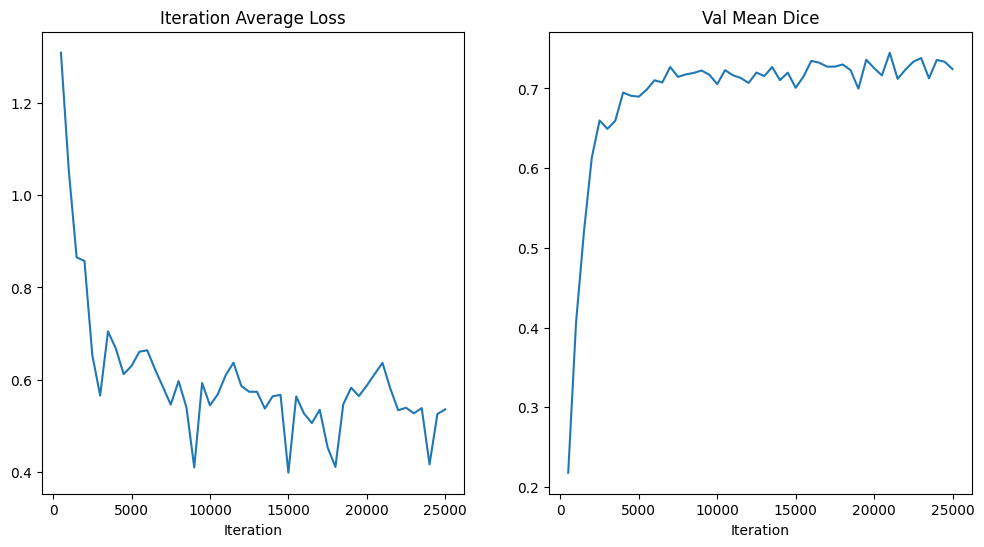

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

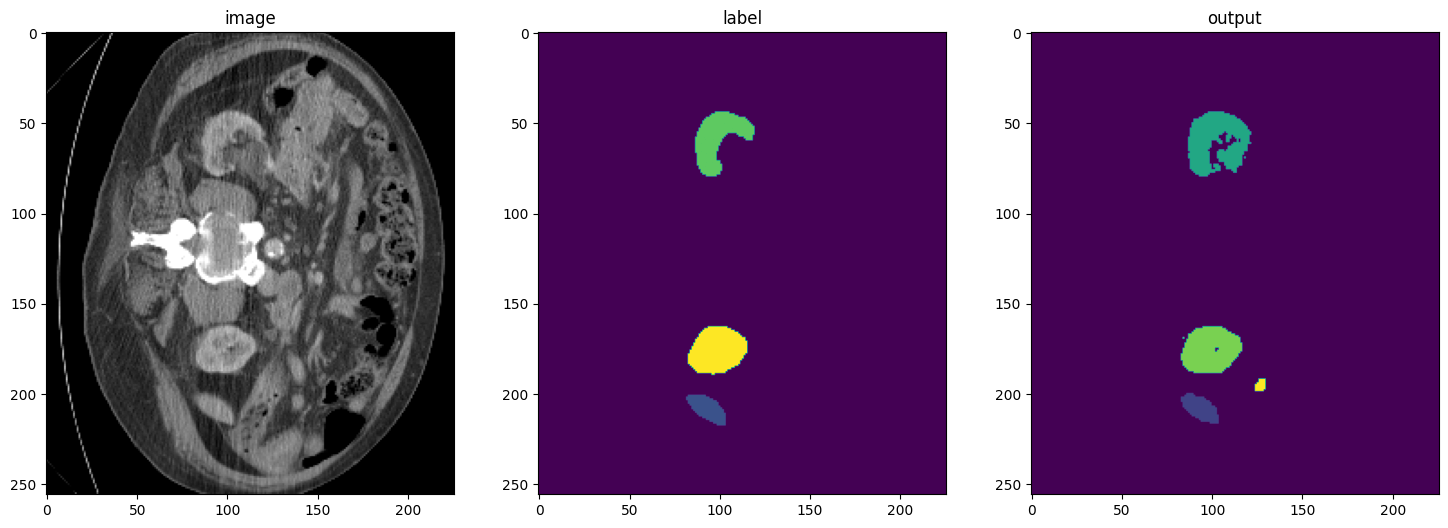

In [17]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold3_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [6]:
split_json = "dataset_4.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.14it/s]


image shape: torch.Size([1, 229, 192, 220]), label shape: torch.Size([1, 229, 192, 220])


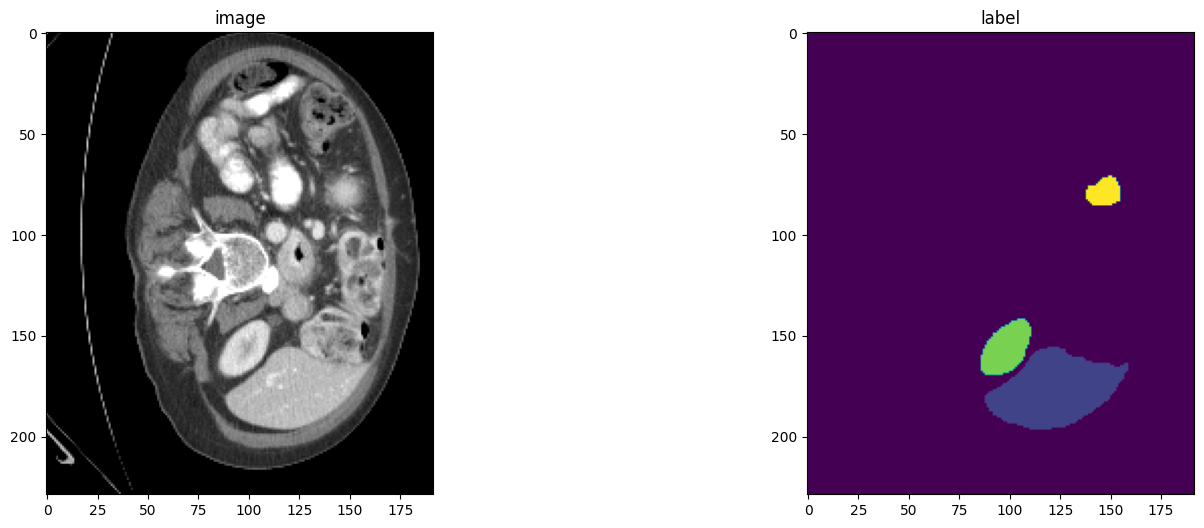

In [7]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
slice_map = {
    "img0001.nii.gz": 125,
    "img0002.nii.gz": 230,
    "img0003.nii.gz": 204,
    "img0004.nii.gz": 204,
    "img0005.nii.gz": 204,
    "img0006.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [9]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [11]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.06977): 100%|█| 24/24 [00:23<00:00,  1.03it/
Training (47 / 25000 Steps) (loss=1.91200): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=1.83222): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=1.66366): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=1.69761): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (143 / 25000 Steps) (loss=1.55871): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (167 / 25000 Steps) (loss=1.52926): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (191 / 25000 Steps) (loss=1.37334): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=1.34782): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=1.40703): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (263 / 25000 Steps) (loss=1.41110): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.18305): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2407514601945877 Current Avg. Dice: 0.2407514601945877


Training (503 / 25000 Steps) (loss=1.12358): 100%|█| 24/24 [00:31<00:00,  1.31s/
Training (527 / 25000 Steps) (loss=1.30029): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (551 / 25000 Steps) (loss=1.14361): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.07945): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (599 / 25000 Steps) (loss=1.13497): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (623 / 25000 Steps) (loss=1.06391): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (647 / 25000 Steps) (loss=1.12483): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=1.07033): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (695 / 25000 Steps) (loss=1.26250): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.13513): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.18315): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (767 / 25000 Steps) (loss=1.04765): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3868216276168823 Current Avg. Dice: 0.3868216276168823


Training (1007 / 25000 Steps) (loss=1.03213): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (1031 / 25000 Steps) (loss=1.02048): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1055 / 25000 Steps) (loss=0.96963): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1079 / 25000 Steps) (loss=0.86758): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.97228): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1127 / 25000 Steps) (loss=0.90116): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1151 / 25000 Steps) (loss=0.91619): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1175 / 25000 Steps) (loss=0.95534): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1199 / 25000 Steps) (loss=0.95101): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1223 / 25000 Steps) (loss=0.95672): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1247 / 25000 Steps) (loss=1.02814): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.93988): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5813999772071838 Current Avg. Dice: 0.5813999772071838


Training (1511 / 25000 Steps) (loss=0.88035): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (1535 / 25000 Steps) (loss=0.87244): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1559 / 25000 Steps) (loss=0.86332): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1583 / 25000 Steps) (loss=1.07017): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1607 / 25000 Steps) (loss=0.84022): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1631 / 25000 Steps) (loss=0.97899): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1655 / 25000 Steps) (loss=0.98364): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.72344): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.92100): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1727 / 25000 Steps) (loss=0.79871): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1751 / 25000 Steps) (loss=0.72121): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (1775 / 25000 Steps) (loss=0.80543): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6402206420898438 Current Avg. Dice: 0.6402206420898438


Training (2015 / 25000 Steps) (loss=0.74144): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (2039 / 25000 Steps) (loss=0.79222): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2063 / 25000 Steps) (loss=0.70273): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2087 / 25000 Steps) (loss=0.76583): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2111 / 25000 Steps) (loss=0.86264): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2135 / 25000 Steps) (loss=0.78839): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2159 / 25000 Steps) (loss=0.74550): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2183 / 25000 Steps) (loss=0.63995): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2207 / 25000 Steps) (loss=0.72270): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2231 / 25000 Steps) (loss=0.77663): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2255 / 25000 Steps) (loss=0.77161): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=0.71157): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.719476044178009 Current Avg. Dice: 0.719476044178009


Training (2519 / 25000 Steps) (loss=0.74009): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (2543 / 25000 Steps) (loss=0.82184): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2567 / 25000 Steps) (loss=0.68535): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.96699): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2615 / 25000 Steps) (loss=0.80418): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2639 / 25000 Steps) (loss=0.63207): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.55307): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2687 / 25000 Steps) (loss=0.74370): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2711 / 25000 Steps) (loss=0.65752): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2735 / 25000 Steps) (loss=0.82517): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.77933): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2783 / 25000 Steps) (loss=0.91753): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7412694096565247 Current Avg. Dice: 0.7412694096565247


Training (3023 / 25000 Steps) (loss=0.85260): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (3047 / 25000 Steps) (loss=0.84071): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.82711): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3095 / 25000 Steps) (loss=0.65351): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=1.09461): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.84369): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3167 / 25000 Steps) (loss=0.83930): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3191 / 25000 Steps) (loss=0.77486): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3215 / 25000 Steps) (loss=0.76061): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.61129): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3263 / 25000 Steps) (loss=0.59513): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3287 / 25000 Steps) (loss=0.77938): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7467684745788574 Current Avg. Dice: 0.7467684745788574


Training (3503 / 25000 Steps) (loss=0.54349): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (3527 / 25000 Steps) (loss=0.83305): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.77717): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.80009): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3599 / 25000 Steps) (loss=0.70792): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3623 / 25000 Steps) (loss=0.72730): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.78587): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.75567): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3695 / 25000 Steps) (loss=0.67256): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.44312): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3743 / 25000 Steps) (loss=0.78358): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.71683): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7467684745788574 Current Avg. Dice: 0.7072205543518066


Training (4007 / 25000 Steps) (loss=0.61961): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (4031 / 25000 Steps) (loss=0.64554): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.62435): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4079 / 25000 Steps) (loss=0.54661): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.75947): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4127 / 25000 Steps) (loss=0.76966): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.63460): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.71767): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.79451): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=0.62240): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.51628): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4271 / 25000 Steps) (loss=0.67763): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7609644532203674 Current Avg. Dice: 0.7609644532203674


Training (4511 / 25000 Steps) (loss=0.60746): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (4535 / 25000 Steps) (loss=0.58692): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4559 / 25000 Steps) (loss=0.65813): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4583 / 25000 Steps) (loss=0.68097): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4607 / 25000 Steps) (loss=0.57295): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4631 / 25000 Steps) (loss=0.55699): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.55218): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4679 / 25000 Steps) (loss=0.59840): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.56991): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.84658): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.51412): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4775 / 25000 Steps) (loss=0.71122): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7609644532203674 Current Avg. Dice: 0.7417474389076233


Training (5015 / 25000 Steps) (loss=0.99840): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (5039 / 25000 Steps) (loss=0.69420): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.58441): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5087 / 25000 Steps) (loss=0.60641): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5111 / 25000 Steps) (loss=0.69274): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5135 / 25000 Steps) (loss=0.72705): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5159 / 25000 Steps) (loss=0.63455): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5183 / 25000 Steps) (loss=0.80134): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=0.64043): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5231 / 25000 Steps) (loss=0.64338): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5255 / 25000 Steps) (loss=0.68986): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5279 / 25000 Steps) (loss=0.72590): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7737550735473633 Current Avg. Dice: 0.7737550735473633


Training (5519 / 25000 Steps) (loss=0.50433): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (5543 / 25000 Steps) (loss=0.50860): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5567 / 25000 Steps) (loss=0.74544): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5591 / 25000 Steps) (loss=0.70717): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=1.40851): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.64876): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5663 / 25000 Steps) (loss=0.57966): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.61608): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5711 / 25000 Steps) (loss=0.44116): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5735 / 25000 Steps) (loss=0.57249): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.73379): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5783 / 25000 Steps) (loss=0.65348): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7737550735473633 Current Avg. Dice: 0.7668552994728088


Training (6023 / 25000 Steps) (loss=0.72510): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (6047 / 25000 Steps) (loss=0.71124): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6071 / 25000 Steps) (loss=0.53029): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6095 / 25000 Steps) (loss=0.69880): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.69519): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6143 / 25000 Steps) (loss=0.61570): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6167 / 25000 Steps) (loss=0.67932): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6191 / 25000 Steps) (loss=0.71816): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.63852): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6239 / 25000 Steps) (loss=0.68845): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6263 / 25000 Steps) (loss=0.57821): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6287 / 25000 Steps) (loss=0.56735): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7743852734565735 Current Avg. Dice: 0.7743852734565735


Training (6503 / 25000 Steps) (loss=0.61016): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (6527 / 25000 Steps) (loss=0.74466): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6551 / 25000 Steps) (loss=0.64089): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6575 / 25000 Steps) (loss=0.74644): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6599 / 25000 Steps) (loss=0.60057): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.61103): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6647 / 25000 Steps) (loss=0.48878): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.48375): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.74595): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6719 / 25000 Steps) (loss=0.46103): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.27935): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6767 / 25000 Steps) (loss=0.64342): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7743852734565735 Current Avg. Dice: 0.7309471964836121


Training (7007 / 25000 Steps) (loss=0.52716): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (7031 / 25000 Steps) (loss=0.76125): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7055 / 25000 Steps) (loss=0.72559): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7079 / 25000 Steps) (loss=0.83232): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7103 / 25000 Steps) (loss=0.73652): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.48309): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7151 / 25000 Steps) (loss=0.62611): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7175 / 25000 Steps) (loss=0.57843): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7199 / 25000 Steps) (loss=0.71674): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7223 / 25000 Steps) (loss=0.57598): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.50732): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.45130): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7744505405426025 Current Avg. Dice: 0.7744505405426025


Training (7511 / 25000 Steps) (loss=0.47474): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (7535 / 25000 Steps) (loss=0.54373): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7559 / 25000 Steps) (loss=0.59792): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7583 / 25000 Steps) (loss=0.49159): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7607 / 25000 Steps) (loss=0.63633): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7631 / 25000 Steps) (loss=0.50437): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.72407): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7679 / 25000 Steps) (loss=0.73105): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7703 / 25000 Steps) (loss=0.54004): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.67112): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.55047): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7775 / 25000 Steps) (loss=0.67571): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7774786949157715 Current Avg. Dice: 0.7774786949157715


Training (8015 / 25000 Steps) (loss=0.41138): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (8039 / 25000 Steps) (loss=0.59699): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.63502): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8087 / 25000 Steps) (loss=0.58588): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8111 / 25000 Steps) (loss=0.62742): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8135 / 25000 Steps) (loss=0.57690): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.50895): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8183 / 25000 Steps) (loss=0.63032): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.58917): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=1.00449): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.80085): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8279 / 25000 Steps) (loss=0.55114): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7794756889343262 Current Avg. Dice: 0.7794756889343262


Training (8519 / 25000 Steps) (loss=0.67365): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (8543 / 25000 Steps) (loss=0.40494): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8567 / 25000 Steps) (loss=0.69734): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8591 / 25000 Steps) (loss=0.76424): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8615 / 25000 Steps) (loss=0.64131): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8639 / 25000 Steps) (loss=0.36419): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8663 / 25000 Steps) (loss=0.60401): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.65752): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.53221): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=1.04003): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8759 / 25000 Steps) (loss=0.52631): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8783 / 25000 Steps) (loss=0.55153): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7801492214202881 Current Avg. Dice: 0.7801492214202881


Training (9023 / 25000 Steps) (loss=0.58166): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (9047 / 25000 Steps) (loss=0.55441): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9071 / 25000 Steps) (loss=0.72596): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9095 / 25000 Steps) (loss=0.57377): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.63240): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9143 / 25000 Steps) (loss=0.77228): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9167 / 25000 Steps) (loss=0.47722): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9191 / 25000 Steps) (loss=0.71068): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9215 / 25000 Steps) (loss=0.59559): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9239 / 25000 Steps) (loss=0.51654): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9263 / 25000 Steps) (loss=0.66354): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9287 / 25000 Steps) (loss=0.80349): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7801492214202881 Current Avg. Dice: 0.7524824142456055


Training (9503 / 25000 Steps) (loss=0.54740): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (9527 / 25000 Steps) (loss=0.75624): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9551 / 25000 Steps) (loss=0.42477): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9575 / 25000 Steps) (loss=0.40229): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9599 / 25000 Steps) (loss=0.55584): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.33573): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.74098): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.59856): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.40629): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9719 / 25000 Steps) (loss=0.67337): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9743 / 25000 Steps) (loss=0.60250): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.53077): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7801492214202881 Current Avg. Dice: 0.7641838192939758


Training (10007 / 25000 Steps) (loss=0.57445): 100%|█| 24/24 [00:29<00:00,  1.24
Training (10031 / 25000 Steps) (loss=0.69199): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.77296): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10079 / 25000 Steps) (loss=0.66315): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10103 / 25000 Steps) (loss=0.63913): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10127 / 25000 Steps) (loss=0.53520): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10151 / 25000 Steps) (loss=0.49853): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10175 / 25000 Steps) (loss=0.47562): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10199 / 25000 Steps) (loss=0.49134): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.75463): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10247 / 25000 Steps) (loss=0.45521): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.51469): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7801492214202881 Current Avg. Dice: 0.7724043726921082


Training (10511 / 25000 Steps) (loss=0.61614): 100%|█| 24/24 [00:29<00:00,  1.24
Training (10535 / 25000 Steps) (loss=0.58501): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10559 / 25000 Steps) (loss=0.47342): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10583 / 25000 Steps) (loss=0.35786): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.70639): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10631 / 25000 Steps) (loss=0.54395): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.56762): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10679 / 25000 Steps) (loss=0.72211): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10703 / 25000 Steps) (loss=0.53972): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.67988): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10751 / 25000 Steps) (loss=0.59134): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.72002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.8023963570594788


Training (11015 / 25000 Steps) (loss=0.62263): 100%|█| 24/24 [00:30<00:00,  1.26
Training (11039 / 25000 Steps) (loss=0.64766): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.45033): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.72266): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.59038): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11135 / 25000 Steps) (loss=0.64976): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.71976): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.79893): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11207 / 25000 Steps) (loss=0.76431): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11231 / 25000 Steps) (loss=0.42082): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.57950): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.74125): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7854483127593994


Training (11519 / 25000 Steps) (loss=0.59479): 100%|█| 24/24 [00:29<00:00,  1.24
Training (11543 / 25000 Steps) (loss=0.36420): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11567 / 25000 Steps) (loss=0.62574): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.67039): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.80238): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.55199): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.48027): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.56555): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.53829): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11735 / 25000 Steps) (loss=0.68000): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.38455): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11783 / 25000 Steps) (loss=0.59151): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7750232815742493


Training (12023 / 25000 Steps) (loss=0.76797): 100%|█| 24/24 [00:29<00:00,  1.24
Training (12047 / 25000 Steps) (loss=0.39821): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.48277): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12095 / 25000 Steps) (loss=0.28649): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.60618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12143 / 25000 Steps) (loss=0.58571): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.40588): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.72552): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12215 / 25000 Steps) (loss=0.45295): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.57390): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.48041): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12287 / 25000 Steps) (loss=0.55223): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7552855610847473


Training (12503 / 25000 Steps) (loss=0.40009): 100%|█| 24/24 [00:29<00:00,  1.24
Training (12527 / 25000 Steps) (loss=0.76990): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12551 / 25000 Steps) (loss=0.54918): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=0.62271): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.76506): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12623 / 25000 Steps) (loss=0.41050): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.41765): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.72428): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.54747): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.69372): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.47752): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.50102): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7823832035064697


Training (13007 / 25000 Steps) (loss=0.45141): 100%|█| 24/24 [00:29<00:00,  1.24
Training (13031 / 25000 Steps) (loss=0.42399): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13055 / 25000 Steps) (loss=0.42013): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13079 / 25000 Steps) (loss=0.44705): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.75419): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13127 / 25000 Steps) (loss=0.49037): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13151 / 25000 Steps) (loss=0.40141): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13175 / 25000 Steps) (loss=0.61874): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.49738): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13223 / 25000 Steps) (loss=0.42952): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13247 / 25000 Steps) (loss=0.52327): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13271 / 25000 Steps) (loss=0.59968): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7735457420349121


Training (13511 / 25000 Steps) (loss=0.75091): 100%|█| 24/24 [00:29<00:00,  1.24
Training (13535 / 25000 Steps) (loss=0.49078): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13559 / 25000 Steps) (loss=0.65107): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.56989): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13607 / 25000 Steps) (loss=0.37869): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.73745): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13655 / 25000 Steps) (loss=0.60469): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.54980): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13703 / 25000 Steps) (loss=0.57600): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13727 / 25000 Steps) (loss=0.53311): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13751 / 25000 Steps) (loss=0.53227): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13775 / 25000 Steps) (loss=0.60113): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.760273277759552


Training (14015 / 25000 Steps) (loss=0.58551): 100%|█| 24/24 [00:29<00:00,  1.24
Training (14039 / 25000 Steps) (loss=0.47829): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14063 / 25000 Steps) (loss=0.72614): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14087 / 25000 Steps) (loss=0.37915): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14111 / 25000 Steps) (loss=0.50796): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14135 / 25000 Steps) (loss=0.59782): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14159 / 25000 Steps) (loss=0.45951): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14183 / 25000 Steps) (loss=0.48223): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14207 / 25000 Steps) (loss=0.76802): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.59434): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14255 / 25000 Steps) (loss=0.53593): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14279 / 25000 Steps) (loss=0.74252): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7787979245185852


Training (14519 / 25000 Steps) (loss=0.60055): 100%|█| 24/24 [00:29<00:00,  1.24
Training (14543 / 25000 Steps) (loss=0.68655): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.55026): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.67809): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.65734): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14639 / 25000 Steps) (loss=0.39840): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.55194): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.52251): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.64415): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14735 / 25000 Steps) (loss=0.67069): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.43464): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.68569): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7675624489784241


Training (15023 / 25000 Steps) (loss=0.49487): 100%|█| 24/24 [00:29<00:00,  1.24
Training (15047 / 25000 Steps) (loss=0.70404): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15071 / 25000 Steps) (loss=0.52350): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.58394): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15119 / 25000 Steps) (loss=0.63212): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.63665): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15167 / 25000 Steps) (loss=0.37800): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15191 / 25000 Steps) (loss=0.38720): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15215 / 25000 Steps) (loss=0.74324): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.54820): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15263 / 25000 Steps) (loss=0.63415): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.65527): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7702417373657227


Training (15503 / 25000 Steps) (loss=0.59806): 100%|█| 24/24 [00:29<00:00,  1.24
Training (15527 / 25000 Steps) (loss=0.65448): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15551 / 25000 Steps) (loss=0.57314): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15575 / 25000 Steps) (loss=0.66259): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15599 / 25000 Steps) (loss=0.70481): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.68586): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15647 / 25000 Steps) (loss=1.20338): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15671 / 25000 Steps) (loss=0.55179): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15695 / 25000 Steps) (loss=0.54792): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.58321): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.52287): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15767 / 25000 Steps) (loss=0.64040): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7822411060333252


Training (16007 / 25000 Steps) (loss=0.59637): 100%|█| 24/24 [00:29<00:00,  1.24
Training (16031 / 25000 Steps) (loss=0.59915): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16055 / 25000 Steps) (loss=0.34128): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16079 / 25000 Steps) (loss=0.53075): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.46509): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16127 / 25000 Steps) (loss=0.61983): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.70269): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.50225): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.63388): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16223 / 25000 Steps) (loss=0.46583): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.57483): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.66462): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7808768153190613


Training (16511 / 25000 Steps) (loss=0.54329): 100%|█| 24/24 [00:29<00:00,  1.24
Training (16535 / 25000 Steps) (loss=0.46403): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16559 / 25000 Steps) (loss=0.73021): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16583 / 25000 Steps) (loss=0.65891): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16607 / 25000 Steps) (loss=0.68069): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.64364): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16655 / 25000 Steps) (loss=0.79494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16679 / 25000 Steps) (loss=0.52517): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16703 / 25000 Steps) (loss=0.57490): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.38220): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16751 / 25000 Steps) (loss=0.65497): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.41600): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.7893710136413574


Training (17015 / 25000 Steps) (loss=0.52713): 100%|█| 24/24 [00:29<00:00,  1.24
Training (17039 / 25000 Steps) (loss=0.55909): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.33962): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17087 / 25000 Steps) (loss=0.55227): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17111 / 25000 Steps) (loss=0.55315): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17135 / 25000 Steps) (loss=0.52912): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.46426): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.50501): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17207 / 25000 Steps) (loss=0.50505): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17231 / 25000 Steps) (loss=0.55372): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.70119): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.60414): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023963570594788 Current Avg. Dice: 0.725074291229248


Training (17519 / 25000 Steps) (loss=0.48816): 100%|█| 24/24 [00:29<00:00,  1.24
Training (17543 / 25000 Steps) (loss=0.60171): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17567 / 25000 Steps) (loss=0.44429): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17591 / 25000 Steps) (loss=0.76241): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=0.58007): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.45085): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17663 / 25000 Steps) (loss=0.59956): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.43254): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.51495): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.76962): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17759 / 25000 Steps) (loss=0.54423): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.59495): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.8069265484809875


Training (18023 / 25000 Steps) (loss=0.54011): 100%|█| 24/24 [00:30<00:00,  1.25
Training (18047 / 25000 Steps) (loss=0.56723): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.73902): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.67113): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.68985): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18143 / 25000 Steps) (loss=0.39004): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.62547): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.50157): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.63109): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18239 / 25000 Steps) (loss=0.57274): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.59526): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.74201): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7643876075744629


Training (18503 / 25000 Steps) (loss=0.67288): 100%|█| 24/24 [00:29<00:00,  1.24
Training (18527 / 25000 Steps) (loss=0.38760): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.67604): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.66057): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.75106): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18623 / 25000 Steps) (loss=0.54458): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18647 / 25000 Steps) (loss=0.67465): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18671 / 25000 Steps) (loss=0.38089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.65900): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.38966): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.52098): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18767 / 25000 Steps) (loss=0.38485): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.776515007019043


Training (19007 / 25000 Steps) (loss=0.64183): 100%|█| 24/24 [00:29<00:00,  1.24
Training (19031 / 25000 Steps) (loss=0.59398): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19055 / 25000 Steps) (loss=0.62919): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19079 / 25000 Steps) (loss=0.54656): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.55113): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.79026): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.65254): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19175 / 25000 Steps) (loss=0.75317): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.48941): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19223 / 25000 Steps) (loss=0.52668): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19247 / 25000 Steps) (loss=0.65561): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19271 / 25000 Steps) (loss=0.65364): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7485379576683044


Training (19511 / 25000 Steps) (loss=0.58690): 100%|█| 24/24 [00:29<00:00,  1.24
Training (19535 / 25000 Steps) (loss=0.48996): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.64607): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19583 / 25000 Steps) (loss=0.62908): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.53428): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19631 / 25000 Steps) (loss=0.48762): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.50525): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.44830): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.52763): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.45089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.73309): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.54627): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7796719670295715


Training (20015 / 25000 Steps) (loss=0.54260): 100%|█| 24/24 [00:29<00:00,  1.24
Training (20039 / 25000 Steps) (loss=0.83222): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=0.62189): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20087 / 25000 Steps) (loss=0.47905): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.56567): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20135 / 25000 Steps) (loss=0.64130): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.48478): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.66372): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20207 / 25000 Steps) (loss=0.49864): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.68406): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20255 / 25000 Steps) (loss=0.59017): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.55162): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7790946960449219


Training (20519 / 25000 Steps) (loss=0.64705): 100%|█| 24/24 [00:29<00:00,  1.24
Training (20543 / 25000 Steps) (loss=0.56866): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20567 / 25000 Steps) (loss=0.43579): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.37403): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20615 / 25000 Steps) (loss=0.34526): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20639 / 25000 Steps) (loss=0.54400): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20663 / 25000 Steps) (loss=0.69536): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20687 / 25000 Steps) (loss=0.60876): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=0.56485): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20735 / 25000 Steps) (loss=0.54984): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20759 / 25000 Steps) (loss=0.61162): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20783 / 25000 Steps) (loss=0.49366): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7704188823699951


Training (21023 / 25000 Steps) (loss=0.47530): 100%|█| 24/24 [00:29<00:00,  1.24
Training (21047 / 25000 Steps) (loss=0.52545): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.75283): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=0.57179): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.56887): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21143 / 25000 Steps) (loss=0.42472): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.60891): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21191 / 25000 Steps) (loss=0.44214): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21215 / 25000 Steps) (loss=0.52810): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21239 / 25000 Steps) (loss=0.54610): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21263 / 25000 Steps) (loss=0.61301): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21287 / 25000 Steps) (loss=0.52246): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7682033181190491


Training (21503 / 25000 Steps) (loss=0.57334): 100%|█| 24/24 [00:29<00:00,  1.24
Training (21527 / 25000 Steps) (loss=0.65128): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.64501): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21575 / 25000 Steps) (loss=0.55527): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21599 / 25000 Steps) (loss=0.62111): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21623 / 25000 Steps) (loss=0.64031): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.48471): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.63498): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.43563): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21719 / 25000 Steps) (loss=0.51015): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.52989): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.48647): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7794610857963562


Training (22007 / 25000 Steps) (loss=0.49011): 100%|█| 24/24 [00:29<00:00,  1.24
Training (22031 / 25000 Steps) (loss=0.58457): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22055 / 25000 Steps) (loss=0.31548): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22079 / 25000 Steps) (loss=0.68796): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22103 / 25000 Steps) (loss=0.54936): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.53895): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.58416): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.58009): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.39295): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22223 / 25000 Steps) (loss=0.75025): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.51617): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22271 / 25000 Steps) (loss=0.62646): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.749021589756012


Training (22511 / 25000 Steps) (loss=0.47831): 100%|█| 24/24 [00:29<00:00,  1.24
Training (22535 / 25000 Steps) (loss=0.35985): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.51075): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22583 / 25000 Steps) (loss=0.56760): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.58626): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.59690): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22655 / 25000 Steps) (loss=0.60034): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22679 / 25000 Steps) (loss=0.66924): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.33999): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.59585): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=0.63475): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22775 / 25000 Steps) (loss=0.42338): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7609047889709473


Training (23015 / 25000 Steps) (loss=0.71842): 100%|█| 24/24 [00:29<00:00,  1.24
Training (23039 / 25000 Steps) (loss=0.58415): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.59731): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.57365): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.68691): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.57983): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23159 / 25000 Steps) (loss=0.73424): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23183 / 25000 Steps) (loss=0.56155): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.68765): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23231 / 25000 Steps) (loss=0.49051): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.39997): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.60233): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.8037035465240479


Training (23519 / 25000 Steps) (loss=0.44343): 100%|█| 24/24 [00:29<00:00,  1.24
Training (23543 / 25000 Steps) (loss=0.50120): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.54592): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.42685): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.30489): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23639 / 25000 Steps) (loss=0.43125): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23663 / 25000 Steps) (loss=0.43055): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.67235): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.57136): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.62373): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.59707): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23783 / 25000 Steps) (loss=0.57721): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7924230694770813


Training (24023 / 25000 Steps) (loss=0.58053): 100%|█| 24/24 [00:29<00:00,  1.24
Training (24047 / 25000 Steps) (loss=0.60664): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.39358): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.54328): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.55082): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.43349): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.46653): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.78250): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.46478): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24239 / 25000 Steps) (loss=0.69420): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.54024): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.61618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.7727904319763184


Training (24503 / 25000 Steps) (loss=0.38581): 100%|█| 24/24 [00:29<00:00,  1.24
Training (24527 / 25000 Steps) (loss=0.46258): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.53038): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.52798): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24599 / 25000 Steps) (loss=0.49501): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.48710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24647 / 25000 Steps) (loss=0.43794): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24671 / 25000 Steps) (loss=0.47091): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.55793): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24719 / 25000 Steps) (loss=0.39547): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24743 / 25000 Steps) (loss=0.53981): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.42864): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8069265484809875 Current Avg. Dice: 0.8013655543327332


Training (25007 / 25000 Steps) (loss=0.52110): 100%|█| 24/24 [00:29<00:00,  1.24


<All keys matched successfully>

In [12]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8069 at iteration: 18000


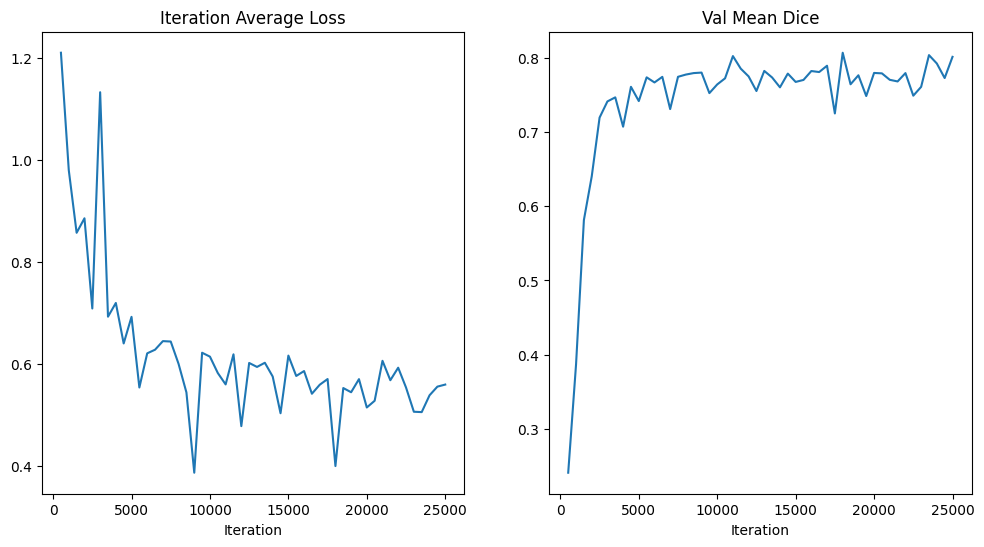

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

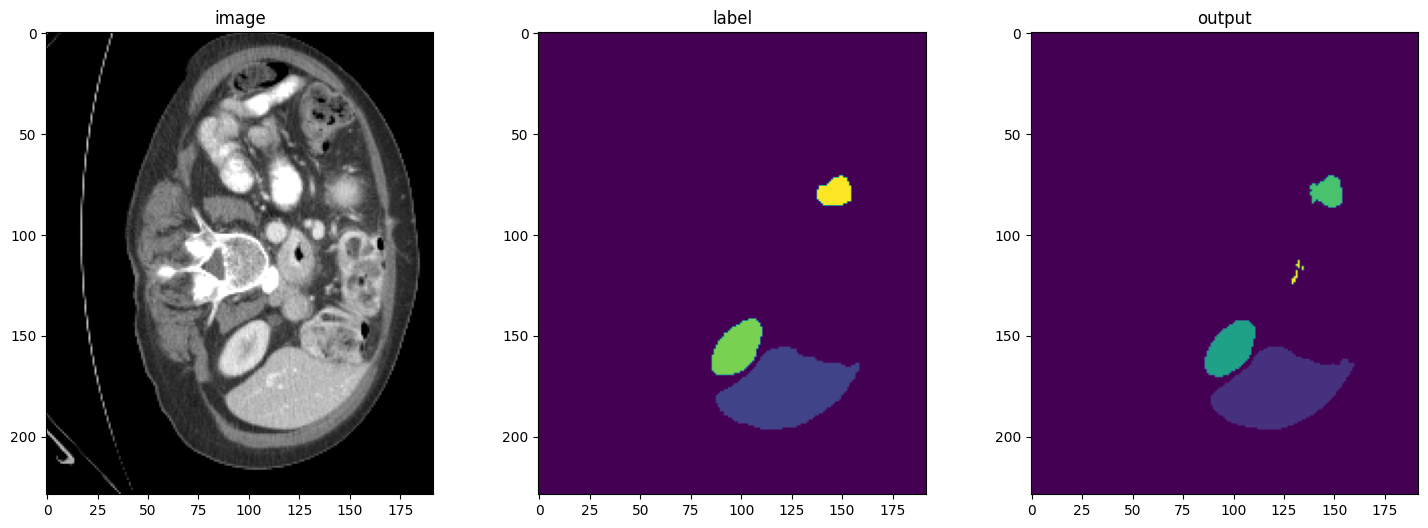

In [14]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold3_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()